In [ ]:
!pip install bt

!pip install yfinance

import bt
import yfinance as yf

import pandas as pd
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
%matplotlib inline



In [ ]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [ ]:
def cdi_acumulado(data_inicio, data_fim):
  cdi = consulta_bc(12)
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [ ]:
data_inicio = '2015-01-02'
data_fim    = '2020-06-29'

In [ ]:
cdi = cdi_acumulado(data_inicio=data_inicio, data_fim=data_fim)

tickers_carteira = ['BOVA11.SA', 'SMAL11.SA']
carteira = yf.download(tickers_carteira, start=data_inicio, end=data_fim)['Adj Close']
carteira['renda_fixa'] = cdi
carteira.dropna(inplace=True)


In [ ]:
carteira.columns

Index(['BOVA11.SA', 'SMAL11.SA', 'renda_fixa'], dtype='object')

In [ ]:
#tirando o SA para poder passar o peso na estrategia
carteira.columns = carteira.columns.str.rstrip('.SA')
carteira

,BOVA11,SMAL11,renda_fixa
Date,,,
2015-01-02,47.259998,52.020000,1.000000
2015-01-05,46.320000,50.549999,1.000869
2015-01-06,46.580002,50.000000,1.001304
2015-01-07,48.150002,51.250000,1.001739
2015-01-08,48.509998,52.000000,1.002175
...,...,...,...
2020-06-22,91.750000,108.599998,1.627421
2020-06-23,92.260002,110.330002,1.627558
2020-06-24,90.769997,107.010002,1.627695


In [ ]:
#nome, lista com algoriti
#rebalanciamento = bt.Strategy('rebalanciamento',
#                              [bt.algos.RunMonthly(run_on_end_of_period=True), #roda uma ves por mes, so no final do mes
#                               bt.algos.SelectAll(), # seleciona todos ativos
#                               bt.algos.WeighEqually(), #mesmos pesos
#                               bt.algos.Rebalance() # executa a estrategi de rebalanciamento
#                               ])
rebalanceamento = bt.Strategy('rebalanceamento', 
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                # bt.algos.WeighEqually(),
                 bt.algos.CapitalFlow(10000), #um aporte 10000 toda vez que roda o rebalanciamento
                 bt.algos.WeighSpecified(BOVA11=0.4,SMAL11=0.4, renda_fixa=0.2),
                 bt.algos.Rebalance()])

In [ ]:
#buy_hold = bt.Strategy('Buy&Hold',
#                              [bt.algos.RunOnce, 
#                               bt.algos.SelectAll(), # seleciona todos ativos
#                               bt.algos.WeighEqually(), #mesmos pesos
#                               bt.algos.Rebalance() # executa a estrategi 1 vez
#                              ])
buy_hold = bt.Strategy('Buy&Hold', 
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     #bt.algos.WeighSpecified(BOVA11=0.4,SMAL11=0.4, renda_fixa=0.2),
                     bt.algos.Rebalance()]
                    )

In [ ]:
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira[['BOVA11', 'SMAL11']])

In [ ]:
resultados = bt.run(bt1, bt2)

rebalanceamento
0% [############################# ] 100% | ETA: 00:00:00Buy&Hold
0% [############################# ] 100% | ETA: 00:00:00

In [ ]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2015-01-01         2015-01-01
End                  2020-06-26         2020-06-26
Risk-free rate       0.00%              0.00%

Total Return         97.05%             96.80%
Daily Sharpe         0.70               0.60
Daily Sortino        1.05               0.90
CAGR                 13.17%             13.14%
Max Drawdown         -40.19%            -49.28%
Calmar Ratio         0.33               0.27

MTD                  7.49%              9.33%
3m                   16.97%             19.89%
6m                   -15.64%            -21.54%
YTD                  -15.08%            -20.90%
1Y                   1.75%              -1.63%
3Y (ann.)            15.10%             16.11%
5Y (ann.)            13.66%             13.76%
10Y (ann.)           13.17%             13.14%
Since Incep. (ann.)  13.17%             13.14%

Daily Sharpe         0.70               0.60
Dai

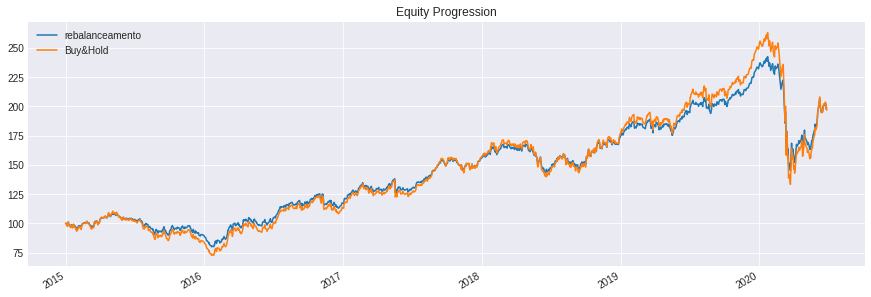

In [ ]:
resultados.plot()

In [ ]:
resultados.get_transactions()

price  quantity
Date       Security                       
2015-01-02 BOVA11      47.259998    8548.0
           SMAL11      52.020000    7766.0
           renda_fixa   1.000000  202000.0
2015-01-30 BOVA11      45.610001     -67.0
           SMAL11      46.790001     502.0
...                          ...       ...
2020-04-30 SMAL11      90.419998    -404.0
           renda_fixa   1.620973   30770.0
2020-05-29 BOVA11      84.150002    -381.0
           SMAL11      94.650002     134.0
           renda_fixa   1.624795   18057.0

[197 rows x 2 columns]

In [ ]:
resultados.get_security_weights()#mostra os pesos

,BOVA11,SMAL11,renda_fixa
2015-01-01,0.000000,0.000000,0.000000
2015-01-02,0.399979,0.399987,0.200000
2015-01-05,0.399650,0.396247,0.204068
2015-01-06,0.402691,0.392713,0.204562
2015-01-07,0.406714,0.393296,0.199956
...,...,...,...
2020-06-22,0.398117,0.418964,0.182877
2020-06-23,0.396797,0.421883,0.181278
2020-06-24,0.397985,0.417150,0.184821
2020-06-25,0.399950,0.417516,0.182492


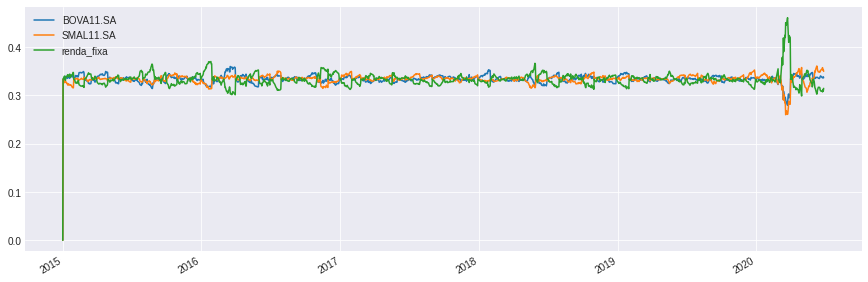

In [ ]:
resultados.plot_security_weights()